In [1]:
!nvidia-smi

Sun Jul 30 04:28:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:21:00.0 Off |                   On |
| N/A   29C    P0    35W / 250W |  25585MiB / 40960MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

In [13]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d isaacritharson/severity-based-rice-leaf-diseases-dataset

100%|███████████████████████████████████████▉| 942M/943M [01:49<00:00, 9.56MB/s]
100%|████████████████████████████████████████| 943M/943M [01:49<00:00, 9.02MB/s]


In [7]:
!unzip  severity-based-rice-leaf-diseases-dataset.zip

Archive:  severity-based-rice-leaf-diseases-dataset.zip
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_095504.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_095521.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_095611.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_095629.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_095648.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100056.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100157.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100200.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100204.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100214.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100239.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_20190419_100418.jpg  
  inflating: Leaf Disease Dataset/train/Healthy/IMG_2019

## Install Dependencies

In [3]:
!pip install lightning watermark kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 49.1 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110686 sha256=be8a725bfa45811e8bd7669a39be627f5b8547fd480dd7db6fae149f6f267ea0
  Stored in directory: /home/vitap/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip inst

In [2]:
%load_ext watermark
%watermark -p torch,lightning,torchvision

2023-07-30 04:02:37.457213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 04:02:38.102154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch      : 2.0.0
lightning  : 2.0.6
torchvision: 0.15.1



## Initialize

In [2]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel,Cifar10DataModule, plot_loss_and_acc, RiceDataModule

2023-07-30 19:30:48.221378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 19:30:48.885070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
entrypoints = torch.hub.list('pytorch/vision:v0.13.0', force_reload=True)
for e in entrypoints:
    if "vit" in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /home/vitap/.cache/torch/hub/v0.13.0.zip


vit_b_16
vit_b_32
vit_h_14
vit_l_16
vit_l_32


In [9]:
pytorch_model = torch.hub.load('pytorch/vision:v0.13.0', 'vit_b_16', weights='IMAGENET1K_V1')

Using cache found in /home/vitap/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/vitap/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:31<00:00, 11.0MB/s] 


In [11]:
pytorch_model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [13]:
#for param in pytorch_model.parameters():
#    param.requires_grad = False
# add last layer

# pytorch_model.fc = torch.nn.Linear(512, 9)
# Get the number of input features for the last layer
num_features = pytorch_model.heads[-1].in_features

# Define the last layer with 9 output classes
last_layer = nn.Linear(num_features, 9)

# Replace the last layer of the MobileNetV2 model with the new last_layer
pytorch_model.heads[-1] = last_layer

# The MobileNetV2 model now has the last layer with 9 output classes
print(pytorch_model)






VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

#Custom Transform
Also, we now have to keep in mind the preprocessing protocol that was used for pre-training the model:

In [14]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Tensorboard

In [15]:
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")

### Callback

In [21]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [16]:
%%capture --no-display

L.pytorch.seed_everything(123)

dm = RiceDataModule(batch_size=64, num_workers=4,
                       train_transform=preprocess_transform,
                       test_transform=preprocess_transform)

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    callbacks=callbacks, 
    max_epochs=50,
    accelerator="gpu",
    devices=[0],
    logger=CSVLogger(save_dir="logs/", name="my-model1"),
    # logger=logger,
    deterministic=True,
)

Global seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model=lightning_model, datamodule=dm)

You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 7g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | VisionTransformer  | 85.8 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.222   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/vitap/miniconda3/envs/torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


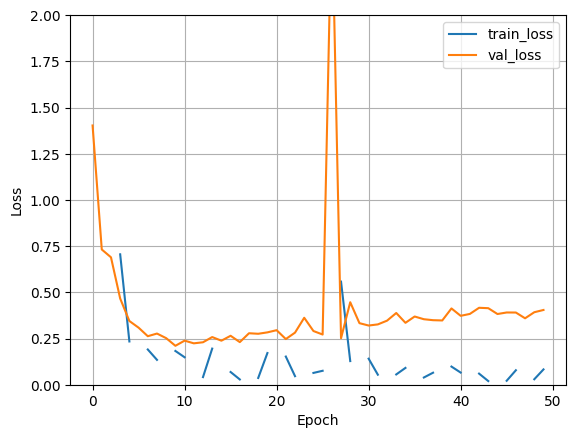

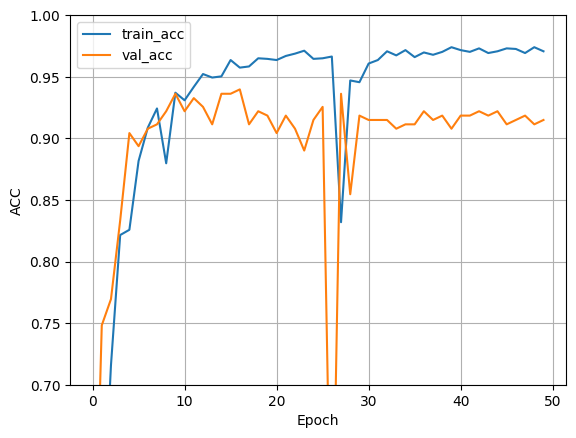

In [18]:
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0))


In [19]:
trainer.test(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.955294132232666     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.955294132232666}]

In [48]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9670588374137878     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9670588374137878}]

In [20]:
torch.save(pytorch_model.state_dict(), "vit_b_16-50.pt")

In [31]:
!tar -xvf /content/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [41]:
!tree -L 2 "/content/LeafDiseaseDataset/"

/content/LeafDiseaseDataset/
├── train
│   ├── Healthy
│   ├── Mild Bacterial blight
│   ├── Mild Blast
│   ├── Mild Brownspot
│   ├── Mild Tungro
│   ├── Severe Bacterial blight
│   ├── Severe Blast
│   ├── Severe Brownspot
│   └── Severe Tungro
└── validation
    ├── Healthy
    ├── Mild Bacterial blight
    ├── Mild Blast
    ├── Mild Brownspot
    ├── Mild Tungro
    ├── Severe Bacterial blight
    ├── Severe Blast
    ├── Severe Brownspot
    └── Severe Tungro

20 directories, 0 files


In [53]:
!cp -r /content/LeafDiseaseDataset/validation/* /content/LeafDiseaseDataset/train/

cp: cannot stat '/content/LeafDiseaseDataset/validation/*': No such file or directory


In [58]:
from torchvision import datasets, models, transforms

In [76]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize(299),
        transforms.CenterCrop(299),
#         transforms.RandomResizedCrop(299),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [77]:
device = "cuda" if torch.cuda.is_available() else "cpu"
val_path="/content/Leaf Disease Dataset/validation"
train_path = "/content/Leaf Disease Dataset/train"

## Classes

In [78]:
from torchvision.datasets import ImageFolder
dataset=ImageFolder(train_path,transform=data_transforms["train"])
img,label=dataset[0]
print(img.shape,label)
print(dataset.classes)

torch.Size([3, 299, 299]) 0
['Healthy', 'Mild Bacterial blight', 'Mild Blast', 'Mild Brownspot', 'Mild Tungro', 'Severe Bacterial blight', 'Severe Blast', 'Severe Brownspot', 'Severe Tungro']


In [79]:
len(dataset)

2826

In [80]:
dataset1=ImageFolder(val_path,transform=data_transforms["val"])
img,label=dataset1[0]
print(img.shape,label)
print(dataset.classes)

torch.Size([3, 299, 299]) 0
['Healthy', 'Mild Bacterial blight', 'Mild Blast', 'Mild Brownspot', 'Mild Tungro', 'Severe Bacterial blight', 'Severe Blast', 'Severe Brownspot', 'Severe Tungro']


In [82]:
len(dataset1)

180

In [83]:
from torch.utils.data import Subset